Простой бейзлайн для задачи рекомендации товаров https://retailhero.ai/c/recommender_system/overview  
Скор ниже бейзлайна организаторов: 0.015 на валидации и 0.013 на паблике.

Использованная модель неэффективна, т.к. включает только 225 самых популярных товаров и две фичи (возраст и пол).  
Предполагается, что в докере только CPU. Поэтому используется классификатор без подддержки GPU, он очень долго тренируется.   
Ноутбук просто показывает, как сохранять модель и метки товаров для предсказания в докере. 

In [1]:
import pandas as pd
import numpy as np
import pickle
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
#from sklearn.model_selection import train_test_split

In [2]:
df_clients = pd.read_csv('data/clients.csv')[['client_id', 'age','gender']]
df_purchases = pd.read_csv('data/purchases.csv')[['client_id', 'product_id']]
#df_products = pd.read_csv('data/products.csv')

In [3]:
#Количество товаров
df_purchases.product_id.nunique()

42530

In [4]:
#Оставляем только самые популярные товары для упрощенного классификатора (250 наименований из 42 тыс)
top_product = list(df_purchases.product_id[df_purchases.product_id.value_counts(ascending=False)[0:250]])
df_purchases =  df_purchases.loc[df_purchases['product_id'].isin(top_product)] 

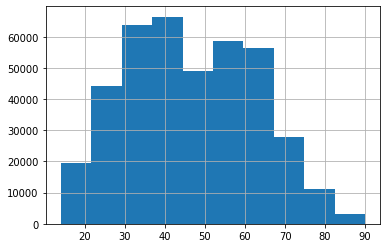

In [5]:
%matplotlib inline
df_clients.age.clip(14, 90).hist()

In [6]:
#удалить или исправить строки с неправильным возрастом
#df_clients.age.clip(14, 90).value_counts(ascending=True)[0:10]
df_clients = df_clients.loc[(df_clients['age'] >= 14) & (df_clients['age'] <= 90)]
df_clients['age'] = df_clients['age'].astype('int8')

In [7]:
df_clients.gender.value_counts(dropna=False)

U    184375
F    147567
M     66351
Name: gender, dtype: int64

In [8]:
#Кодирование пола для модели
df_clients['gender']=df_clients['gender'].map({'U':2, 'F':1, 'M':0}).astype('int8')

Подготовка датасета

In [9]:
train = pd.merge(df_clients, df_purchases, how='left', left_on='client_id', right_on='client_id', left_index=True)
train.head()

client_id  age  gender  product_id
7   000012768d   45       2  15ccaa8685
19  000012768d   45       2  4dcf79043e
20  000012768d   45       2  e6f8ac5174
21  000012768d   45       2  439498bce2
37  000012768d   45       2  5645789fdf

In [10]:
del df_clients, df_purchases

In [11]:
#train['age'] = train['age'].astype('int8')
#train['gender'] = train['gender'].astype('int8')

train['product_id'] = train['product_id'].astype(str)
train['client_id'] = train['client_id'].astype(str)

In [12]:
#удаляем пропуски и дубликаты
train.drop_duplicates(keep = "first", inplace=True)
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4195853 entries, 7 to 45786539
Data columns (total 4 columns):
client_id     object
age           int8
gender        int8
product_id    object
dtypes: int8(2), object(2)
memory usage: 104.0+ MB


Подготовка таргета

In [13]:
feature = ['gender', 'age']
y_train = train['product_id']#.astype(str)

In [14]:
y_train.nunique()

225

In [15]:
le = LabelEncoder()
le.fit_transform(y_train)
#le.inverse_transform(y_pred)

array([ 22,  76, 196, ...,   9,  95, 196])

In [16]:
#Сохраняем метки
joblib.dump(le, 'le.pkl') 
#загрузка
#le = joblib.load('le.pkl') 

['le.pkl']

Тренировка простой модели

In [17]:
classifier = LGBMClassifier(objective = 'multiclass', max_depth = 6, n_estimators=100, random_state=42)

In [23]:
%%time
classifier.fit(train[feature], y_train)

CPU times: user 2h 28min 12s, sys: 25 s, total: 2h 28min 37s
Wall time: 43min 48s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=42, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [18]:
#Сохранение модели
joblib.dump(classifier, 'classifier.pkl') 
#загрузка
#classifier = joblib.load('classifier.pkl') 

Прогноз

In [20]:
#В задче запросы поступают по одному
y_pred = classifier.predict_proba(train[feature].head(1))

In [23]:
best_n = np.argsort(y_pred, axis=1)[:,-30:]
best_n

array([[ 14,  39, 161, 219, 138, 144, 215, 183, 176, 196, 107,  82,  27,
         48, 200,  10, 181,  88,  18, 209,  11,  50,  70,  95,  62,  76,
        157, 216,  22,  66]])

In [24]:
recommended = list(le.inverse_transform(best_n[0]))
print(recommended)

['0cbc352942', '298c1acea3', 'c5e3528190', 'f7724d5786', 'a02d521260', 'ac81544ebc', 'f43c12d228', 'de25bccdaf', 'd860464ae1', 'e6f8ac5174', '6d0f84a0ac', '5186e12ff4', '1c257c1a1b', '31dcf71bbd', 'ea27d5dc75', '080ace8748', 'dc2001d036', '5645789fdf', '113e3ace79', 'f098ee2a85', '0a46068efc', '343e841aaa', '439498bce2', '5cb93c9bc5', '3e038662c0', '4dcf79043e', 'bf07df54e1', 'f4599ca21a', '15ccaa8685', '4009f09b04']


В архив solution.zip необходимо положить следующие файлы:
- metadata.json от организаторов, без изменения,
- server.py основной код для загрузки файлов и предскзаний,
- le.pkl метки для этой модели,  
- classifier.pkl сама модель.